In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


In [3]:
trainData = ImageDataGenerator()
trainingdt = trainData.flow_from_directory(directory='RealvsFake/Training', target_size=(224,224))


Found 101965 images belonging to 2 classes.


In [4]:
testData = ImageDataGenerator()
testingdt = testData.flow_from_directory(directory='RealvsFake/Testing', target_size=(224,224))


Found 20076 images belonging to 2 classes.


In [5]:
def preprocess(file_path):
        byte_img = tf.io.read_file(file_path)
        img = tf.io.decode_jpeg(byte_img)
        img = tf.image.resize(img, (224,224))
        img = img / 255.0
        return img

In [6]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [7]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='softsign'))

In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,900,482
Trainable params: 1,312,770
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
resnet_model.compile(optimizer='Adam', loss=tf.keras.losses.CosineSimilarity(axis=-1), metrics=['accuracy'])

history = resnet_model.fit(trainingdt, validation_data=testingdt, epochs=10, steps_per_epoch=100, validation_steps=10)

Epoch 1/10
100/100 [==============================] - 625s 6s/step - loss: -0.6885 - accuracy: 0.5041 - val_loss: -0.7061 - val_accuracy: 0.5375
Epoch 2/10
100/100 [==============================] - 568s 6s/step - loss: -0.7060 - accuracy: 0.4925 - val_loss: -0.7062 - val_accuracy: 0.5562
Epoch 3/10
100/100 [==============================] - 579s 6s/step - loss: -0.7062 - accuracy: 0.5156 - val_loss: -0.7058 - val_accuracy: 0.5188
Epoch 4/10
100/100 [==============================] - 614s 6s/step - loss: -0.7058 - accuracy: 0.5013 - val_loss: -0.7058 - val_accuracy: 0.5344
Epoch 5/10
100/100 [==============================] - 567s 6s/step - loss: -0.7058 - accuracy: 0.5059 - val_loss: -0.7059 - val_accuracy: 0.5719
Epoch 6/10
100/100 [==============================] - 558s 6s/step - loss: -0.7059 - accuracy: 0.5797 - val_loss: -0.7059 - val_accuracy: 0.6719
Epoch 7/10
100/100 [==============================] - 573s 6s/step - loss: -0.7061 - accuracy: 0.6375 - val_loss: -0.7058 - val_ac

In [15]:
resnet_model.save('resnet50SVMsoftsign.h5')

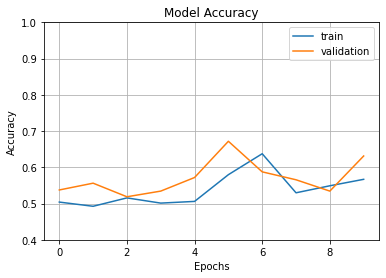

In [16]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

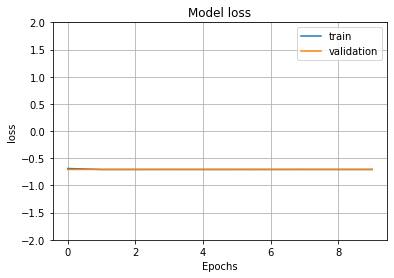

In [18]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=-2,ymax=2)
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
predicts= resnet_model.predict(testingdt)
predictions= resnet_model.reshape(1,-1)[0]
print(classification_report(testingdt, predicts, target_names = ['fake (Class 0)','real (Class 1)']))

In [61]:
from keras.models import load_model
from sklearn.metrics import classification_report
model1= load_model("resnet50SVMsoftsign.h5")
predicts= model1.predict(testingdt)
print(classification_report(predicts,target_names=['fake(class 0)','real(class 1)']))

KeyboardInterrupt: 

In [64]:
y_actual= testingdt.labels
pred= resnet_model.predict(testingdt, batch_size=32)
pred= np.argmax(pred, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(pred, y_actual, target_names=['fake(class0)', 'real(class1)']))

              precision    recall  f1-score   support

fake(class0)       0.12      0.51      0.19      2311
real(class1)       0.89      0.50      0.64     17765

    accuracy                           0.50     20076
   macro avg       0.50      0.50      0.42     20076
weighted avg       0.80      0.50      0.59     20076



[[1142 8888]
 [1169 8877]]


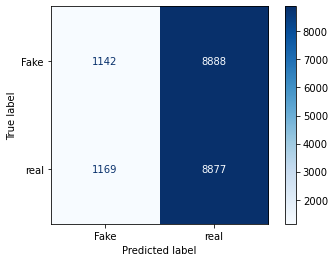

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
y_actual= testingdt.labels
pred= resnet_model.predict(testingdt, batch_size=32)
pred= np.argmax(pred, axis=-1)
cm=confusion_matrix(y_actual,pred)
print(cm)
labels = ["Fake", "real"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()